In [885]:
import numpy as np
import scipy as sp
import sklearn
import sklearn.pipeline
import sklearn.metrics
from sklearn.cross_decomposition import CCA

import matplotlib.pyplot as plt

In [886]:
rng = np.random.default_rng(149)


U_11 = sp.linalg.orth(rng.normal(size=(3,3)))
V_11 = sp.linalg.orth(rng.normal(size=(3,3)))
S_11 = np.diag(np.array([0.93, 0.8, 0.5]))
sgn_1 = np.sign(np.diag((U_11 @ S_11)@ V_11.T))[:,np.newaxis]
V_11 = V_11*sgn_1

A_11 = U_11 @ S_11 @ V_11.T

U_22 = sp.linalg.orth(rng.normal(size=(3,3)))
V_22 = sp.linalg.orth(rng.normal(size=(3,3)))
S_22 = np.diag(np.array([0.96, 0.9, 0.2]))
sgn_2 = np.sign(np.diag((U_22 @ S_22)@ V_22.T))[:,np.newaxis]
V_22 = V_22*sgn_2
A_22 = U_22 @ S_22 @ V_22.T

rho = 0.1
A_21 = np.zeros((3,3))
A_21[0,2] = -rho
A_12 = np.zeros((3,3))
A_12[0,2] = rho


A_1 = np.hstack([A_11, A_21])
A_2 = np.hstack([A_12, A_22])

A = np.vstack([A_1,A_2])
print(np.round(A,1))

sig2 = 0.01**2
Psi_11 = sp.stats.invwishart(df=4,scale=np.eye(3)*sig2,seed=rng).rvs()
Psi_22 = sp.stats.invwishart(df=4,scale=np.eye(3)*sig2,seed=rng).rvs()

Psi_21 = np.zeros((3,3))
Psi_12 = np.zeros((3,3))


Psi_1 = np.hstack([Psi_11, Psi_21])
Psi_2 = np.hstack([Psi_12, Psi_22])

Psi = np.vstack([Psi_1,Psi_2])

_,S,_ =np.linalg.svd(A)
# print(S)

B = 100
T = 2000
T_tot = B + T
Z = rng.multivariate_normal(mean=np.zeros(6),cov=Psi, size=T_tot)

for tt in range(1,T_tot):
    Z[tt,:] = A @ Z[tt-1,:] + Z[tt,:]


X = Z[B:,:3]
Y = Z[B:,3:]

X_n = sp.stats.zscore(X,axis=0)
Y_n = sp.stats.zscore(Y,axis=0)
Z_n = np.hstack([X_n,Y_n])
aa,*_ = np.linalg.lstsq(Z[:-1,:],Z[1:,:],rcond=None)
print(np.round(aa,1).T)


[[ 0.2  0.7  0.2  0.   0.  -0.1]
 [ 0.2  0.1  0.7  0.   0.   0. ]
 [-0.7  0.3  0.   0.   0.   0. ]
 [ 0.   0.   0.1  0.3 -0.6 -0.5]
 [ 0.   0.   0.  -0.5  0.3 -0.8]
 [ 0.   0.   0.  -0.3  0.1  0.2]]
[[ 0.2  0.8  0.2 -0.   0.  -0.1]
 [ 0.2  0.2  0.7 -0.   0.   0. ]
 [-0.7  0.4  0.1 -0.   0.  -0. ]
 [-0.   0.   0.1  0.4 -0.6 -0.5]
 [-0.   0.  -0.  -0.5  0.3 -0.8]
 [ 0.  -0.   0.  -0.4  0.1  0.2]]


[[ 1.    0.4  -0.01  0.11  0.18 -0.06]
 [ 0.4   1.   -0.08  0.04 -0.01 -0.01]
 [-0.01 -0.08  1.    0.07 -0.04  0.  ]
 [ 0.11  0.04  0.07  1.    0.48 -0.74]
 [ 0.18 -0.01 -0.04  0.48  1.   -0.56]
 [-0.06 -0.01  0.   -0.74 -0.56  1.  ]]


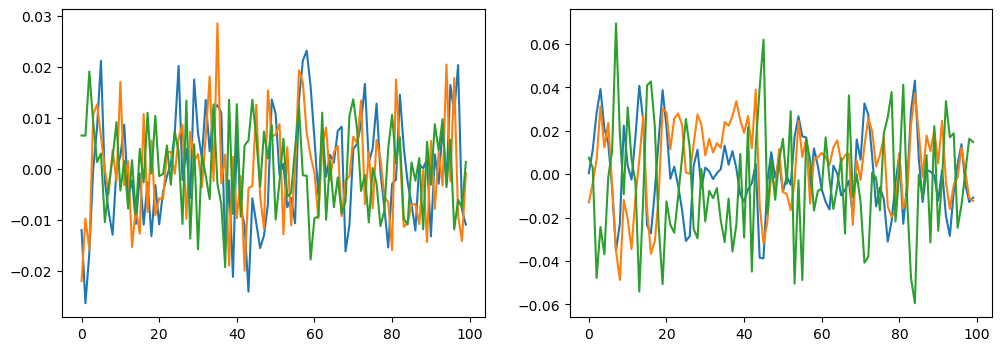

In [887]:

tp = 100
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(X[:tp,:])
plt.subplot(1,2,2)
plt.plot(Y[:tp,:]);

print(np.round(np.cov(X_n.T,Y_n.T),2))


In [888]:
def softthresh(a,c):
    return np.sign(a)*np.maximum(np.abs(a) - c,0)

def threshold_path(w, c):
    rs = np.sort(np.abs(w));

    v = w/np.linalg.norm(w,2)
    if(np.linalg.norm(v,1) <= c):
        delta = 0
    else:
        delta = None
    
    c_min = 0

    for c_max in rs[:-1]:
        if(delta is not None):
            break;
        
        v = softthresh(w,c_min)

        m_max = c_max-c_min

        w2 = np.dot(v,v)
        P = sum(abs(w) > c_min)
        L = np.linalg.norm(v,1)

        c2 = c**2
        L2 = L**2
        P2 = P**2

        aa = (P2 - c2*P)
        bb = (-2*L*P + 2*c2*L)
        cc = (L2 - c2*w2)

        s = bb**2 - 4*aa*cc
        if(s >= 0 and aa != 0):
            d1 = (-bb + np.sqrt(s))/(2*aa)
            d2 = (-bb - np.sqrt(s))/(2*aa)

            if(d1 > d2):
                temp = d1
                d1 = d2
                d2 = temp

            if(d1 >= 0 and d1 < m_max):
                delta = c_min + d1
            elif(d2 >= 0 and d2 < m_max):
                delta = c_min + d2
        elif(aa == 0 and bb != 0):

            d1 = -cc/bb
            if(d1 >= 0 and d1 < m_max):
                delta = c_min + d1

        c_min = c_max
    
    if(delta is None):
        delta = rs[-2]
    
    v = softthresh(w,delta)
    v /= np.linalg.norm(v,2)
    return v, delta


def pmd_cca(X,Y,c1,c2,r=1,iters=100):
    X_n = sp.stats.zscore(X,axis=0)
    Y_n = sp.stats.zscore(Y,axis=0)

    XY = X_n.T @ Y_n

    vs = np.zeros((XY.shape[1],r))
    us = np.zeros((XY.shape[1],r))
    ds = np.zeros((r))

    for ii in range(r):
        _,_,v_0 = np.linalg.svd(XY)
        v = v_0[0,:]
        for _ in range(iters):
            u,_ = threshold_path(XY@v,c1)
            v,_ = threshold_path(u@XY,c2)

        d = u@XY@v

        XY -= d*np.outer(u,v)

        vs[:,ii] = v
        us[:,ii] = u
        ds[ii] = d
    return us,vs,ds

In [898]:
rs = 1
u,v,d=pmd_cca(X_n[:-1,:],Y_n[1:,:],1.01,1.01, r=rs)

for rr in range(rs):
    print(f"d[{rr}]: {d[rr]}")
    print(f"u[{rr}]: {np.round(u[:,rr],3)}, l1 = {np.round(np.linalg.norm(u[:,rr],1),2)}, l2 = {np.round(np.linalg.norm(u[:,rr],2),2)}")
    print(f"v[{rr}]: {np.round(v[:,rr],3)}, l1 = {np.round(np.linalg.norm(v[:,rr],1),2)}, l2 = {np.round(np.linalg.norm(v[:,rr],2),2)}")


d[0]: 201.02522669042702
u[0]: [-0.01  0.    1.  ], l1 = 1.01, l2 = 1.0
v[0]: [ 1.   -0.01 -0.  ], l1 = 1.01, l2 = 1.0


In [899]:
rs = 1
u,v,d=pmd_cca(X_n[1:,:],Y_n[:-1,:],1.01,1.01, r=rs)

for rr in range(rs):
    print(f"d[{rr}]: {d[rr]}")
    print(f"u[{rr}]: {np.round(u[:,rr],3)}, l1 = {np.round(np.linalg.norm(u[:,rr],1),2)}, l2 = {np.round(np.linalg.norm(u[:,rr],2),2)}")
    print(f"v[{rr}]: {np.round(v[:,rr],3)}, l1 = {np.round(np.linalg.norm(v[:,rr],1),2)}, l2 = {np.round(np.linalg.norm(v[:,rr],2),2)}")

d[0]: 469.2104088113301
u[0]: [-1.   -0.    0.01], l1 = 1.01, l2 = 1.0
v[0]: [-0.01 -0.    1.  ], l1 = 1.01, l2 = 1.0


In [891]:
rs = 2
u,v,d=pmd_cca(X_n[:,:],Y_n[:,:],1.01,1.01, r=rs)

for rr in range(rs):
    print(f"d[{rr}]: {d[rr]}")
    print(f"u[{rr}]: {np.round(u[:,rr],3)}, l1 = {np.round(np.linalg.norm(u[:,rr],1),2)}, l2 = {np.round(np.linalg.norm(u[:,rr],2),2)}")
    print(f"v[{rr}]: {np.round(v[:,rr],3)}, l1 = {np.round(np.linalg.norm(v[:,rr],1),2)}, l2 = {np.round(np.linalg.norm(v[:,rr],2),2)}")

d[0]: 365.0853218999009
u[0]: [-1.    0.    0.01], l1 = 1.01, l2 = 1.0
v[0]: [-0.01 -1.    0.  ], l1 = 1.01, l2 = 1.0
d[1]: 224.6718691573146
u[1]: [-1.   -0.   -0.01], l1 = 1.01, l2 = 1.0
v[1]: [-1.    0.    0.01], l1 = 1.01, l2 = 1.0


In [892]:
rs = 1
cca = CCA(n_components=rs,scale=False)
cca.fit(X_n[:-1,:],Y_n[1:,:])
u = cca.x_weights_
v = cca.y_weights_
for rr in range(rs):
    print(f"u[{rr}]: {np.round(u[:,rr],3)}, l1 = {np.round(np.linalg.norm(u[:,rr],1),2)}, l2 = {np.round(np.linalg.norm(u[:,rr],2),2)}")
    print(f"v[{rr}]: {np.round(v[:,rr],3)}, l1 = {np.round(np.linalg.norm(v[:,rr],1),2)}, l2 = {np.round(np.linalg.norm(v[:,rr],2),2)}")


u[0]: [-0.616  0.385  0.687], l1 = 1.69, l2 = 1.0
v[0]: [ 0.839 -0.403  0.367], l1 = 1.61, l2 = 1.0


In [893]:
rs = 1
cca = CCA(n_components=rs,scale=False)
cca.fit(X_n[1:,:],Y_n[:-1,:])
u = cca.x_weights_
v = cca.y_weights_
for rr in range(rs):
    print(f"u[{rr}]: {np.round(u[:,rr],3)}, l1 = {np.round(np.linalg.norm(u[:,rr],1),2)}, l2 = {np.round(np.linalg.norm(u[:,rr],2),2)}")
    print(f"v[{rr}]: {np.round(v[:,rr],3)}, l1 = {np.round(np.linalg.norm(v[:,rr],1),2)}, l2 = {np.round(np.linalg.norm(v[:,rr],2),2)}")

u[0]: [ 0.889 -0.28  -0.361], l1 = 1.53, l2 = 1.0
v[0]: [ 0.475  0.548 -0.689], l1 = 1.71, l2 = 1.0


In [896]:
rs = 1
cca = CCA(n_components=rs,scale=False)
cca.fit(X,Y)
u = cca.x_weights_
v = cca.y_weights_
for rr in range(rs):
    print(f"u[{rr}]: {np.round(u[:,rr],3)}, l1 = {np.round(np.linalg.norm(u[:,rr],1),2)}, l2 = {np.round(np.linalg.norm(u[:,rr],2),2)}")
    print(f"v[{rr}]: {np.round(v[:,rr],3)}, l1 = {np.round(np.linalg.norm(v[:,rr],1),2)}, l2 = {np.round(np.linalg.norm(v[:,rr],2),2)}")

u[0]: [ 0.899 -0.421 -0.125], l1 = 1.44, l2 = 1.0
v[0]: [0.329 0.863 0.383], l1 = 1.58, l2 = 1.0


In [897]:
Sig = np.cov(X.T,Y.T)
Sig_XX = Sig[:3,:3]
Sig_XY = Sig[:3,3:]
Sig_YX = Sig[3:,:3]
Sig_YY = Sig[3:,3:]

M = np.linalg.solve(Sig_XX,Sig_XY)@np.linalg.solve(Sig_YY,Sig_YX)
# uu,ss,vv = np.linalg.svd(M)
_,uu = np.linalg.eig(M)

M = np.linalg.solve(Sig_YY,Sig_YX)@np.linalg.solve(Sig_XX,Sig_XY)
# uu,ss,vv = np.linalg.svd(M)
# print(uu)
_,vv = np.linalg.eig(M)
print(uu)
print(vv)

[[-0.89839666 -0.03832417  0.07004129]
 [ 0.42090948  0.88965623  0.3922337 ]
 [ 0.12537404 -0.45501984  0.91719515]]
[[-0.32916366 -0.90979751  0.2210808 ]
 [-0.86310793  0.26747084  0.25354397]
 [-0.38300912 -0.3173765   0.94172116]]
